### This file is a playground for developing some functions and checking them before putting them in the .py files

In [1]:
# import all files from necessary directory
from os import listdir, path
dir = "/data/Riabova/train/resized_train/"
all_files = [path.join(dir, f) for f in listdir(dir)]
len(all_files)

106

In [2]:
all_files[0]

'/data/Riabova/train/resized_train/15_0_-9_0_0_0_4_2_1689849046042619.hdf5'

In [3]:
import numpy as np
import h5py
# merge all images in one huge array

all_frames_filenames_array = np.empty((1))
frame_nums = np.empty((1))
i = 0
for f in all_files:
    if (i%20 == 0):
        print("File "+str(i)+"...")
    h5_file = h5py.File(f, 'r')
    framesTotal = sum(item.startswith('img_') for item in list(h5_file.keys()))//11
    h5_file.close()
    all_frames_filenames_array = np.concatenate((all_frames_filenames_array, [f]*framesTotal), axis=0)
    frame_nums = np.concatenate((frame_nums, np.arange(0, framesTotal)), axis=0)
    i+=1

File 0...
File 20...
File 40...
File 60...
File 80...
File 100...


In [4]:
all_frames_filenames_array = all_frames_filenames_array[1:]
frame_nums = frame_nums[1:]

X = np.vstack((all_frames_filenames_array, frame_nums)).transpose()
print(X.shape)
print(X[0, :])

(2272, 2)
['/data/Riabova/train/resized_train/15_0_-9_0_0_0_4_2_1689849046042619.hdf5'
 '0.0']


In [5]:
VALID_PERCENT = 0.2
TEST_PERCENT = 0.2
BATCH_TRAIN = 24
BATCH_VALID = 24
BATCH_TEST = 24
# note: original size - 235; resizing to 200 + batch size 5 caused cuda out of memory

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid = train_test_split(X[455:, :], test_size=VALID_PERCENT, random_state=42, shuffle = False)
X_test = X[:455:, :]

print(f"Total training images: {X_train.shape[0]}")
print(f"Total validation images: {X_valid.shape[0]}")
print(f"Total test images: {X_test.shape[0]}")


Total training images: 1453
Total validation images: 364
Total test images: 455


In [7]:
from utils.datasets import CustomMaskDataset, my_collate
import torch

train_dataset = CustomMaskDataset(X_train, maskType='full')
valid_dataset = CustomMaskDataset(X_valid, maskType='full')
test_dataset = CustomMaskDataset(X_test, maskType='full')
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_TRAIN,shuffle=False, collate_fn=my_collate)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_VALID,shuffle=True, collate_fn=my_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False, collate_fn=my_collate)

In [25]:
test_dataset_full = CustomMaskDataset(X_test, maskType='full')
test_dataset = CustomMaskDataset(X_test, maskType='tip')
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False, collate_fn=my_collate)

In [14]:
# Check if all elements of dataset contain original labels
print("Whole dataset contains "+str(len(X))+" frames")

itemsWithLabelsResizedKey = 0
for x in X:
    f = x[0]
    h5_file = h5py.File(f, 'r')
    if 'labels_original' in list(h5_file.keys()):
        itemsWithLabelsResizedKey = itemsWithLabelsResizedKey+1
    h5_file.close()
print("The dataset items, containing corresponding original labels: "+str(itemsWithLabelsResizedKey)+" frames")

Whole dataset contains 1730 frames
The dataset items, containing corresponding original labels: 1730 frames


In [9]:
# To check the speed of accessing data. 
# Result for batch size=10: 2s/batch
# Result for batch size=24: 5s/batch
from tqdm import tqdm
for sample in tqdm(iter(train_dataloader)):
    print(sample['image'].shape)
    break

  0%|          | 0/57 [00:07<?, ?it/s]

torch.Size([24, 1, 128, 128, 128])


### plot 11 augmented versions of same image with masks

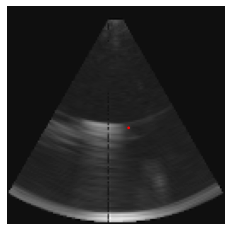

In [9]:
transformNum = i
idx = 10
f = X[idx, 0]
frameNumInt = int(float(X[idx, 1]))
frameNumStr = str(frameNumInt)
h5_file = h5py.File(f, 'r')

img = h5_file["img"+"_"+frameNumStr+"_"+str(transformNum)][()]
img2 = h5_file["img"+"_"+str(frameNumInt-2)+"_"+str(transformNum)][()]
tip_coords = h5_file["labels"+"_"+frameNumStr+"_"+str(transformNum)][()]
mask_full_2 = h5_file["mask"+"_"+str(frameNumInt-2)+"_"+str(transformNum)][()]
tip_coords_original = h5_file["labels_original"][frameNumInt, :]
mask_full = h5_file["mask"+"_"+frameNumStr+"_"+str(transformNum)][()]
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

plt.imshow(img[:, :, int(tip_coords[2])].T, cmap="gray")
#axs[i].imshow(mask_full[:, :, int(tip_coords[2])].T, alpha=0.3, cmap="gray")
axes.add_patch(patches.Circle((int(tip_coords[0]), int(tip_coords[1])), radius=0.5, color='red'))
axes.axis('off')
plt.show()

h5_file.close()

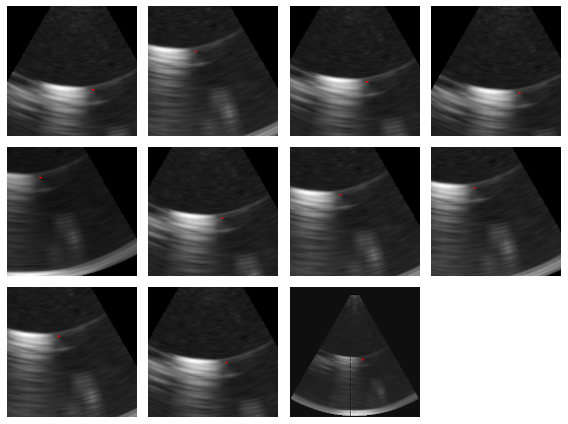

In [8]:
idx = 10
f = X[idx, 0]
frameNumInt = int(float(X[idx, 1]))
frameNumStr = str(frameNumInt)
h5_file = h5py.File(f, 'r')

from matplotlib import pyplot as plt, patches

fig, axs = plt.subplots(3, 4, figsize=(8, 6))
axs = axs.flatten() 

# Plot each data element on subplot
for i in range(0,11):
    
    transformNum = i
    img = h5_file["img"+"_"+frameNumStr+"_"+str(transformNum)][()]
    img2 = h5_file["img"+"_"+str(frameNumInt-2)+"_"+str(transformNum)][()]
    tip_coords = h5_file["labels"+"_"+frameNumStr+"_"+str(transformNum)][()]
    mask_full_2 = h5_file["mask"+"_"+str(frameNumInt-2)+"_"+str(transformNum)][()]
    tip_coords_original = h5_file["labels_original"][frameNumInt, :]
    mask_full = h5_file["mask"+"_"+frameNumStr+"_"+str(transformNum)][()]

    axs[i].imshow(img[:, :, int(tip_coords[2])].T, cmap="gray")
    #axs[i].imshow(mask_full[:, :, int(tip_coords[2])].T, alpha=0.3, cmap="gray")
    axs[i].add_patch(patches.Circle((int(tip_coords[0]), int(tip_coords[1])), radius=0.5, color='red'))
    axs[i].axis('off')
    
axs[11].axis('off')
fig.tight_layout()
plt.show()
h5_file.close()

### Get a maximum and minimum insertion coordinate across all frames

In [22]:
import numpy as np
import h5py
# merge all images in one huge array

all_frames_filenames_array = np.empty((1))
frame_nums = np.empty((1))
min_length = 1000
max_length = 0
i = 0
for f in all_files:
    if (i%20 == 0):
        print("File "+str(i)+"...")
    h5_file = h5py.File(f, 'r')
    framesTotal = sum(item.startswith('img_') for item in list(h5_file.keys()))//11
    min_length_i = h5_file["labels"+"_"+"0"+"_"+str(10)][()]
    max_length_i = h5_file["labels"+"_"+str(framesTotal-1)+"_"+str(10)][()]
    h5_file.close()
    if min_length_i[0]<min_length:
        min_length = min_length_i[0]
    if max_length_i[0]>max_length:
        max_length=max_length_i[0]
    i+=1

File 0...
File 20...


File 40...
File 60...
File 80...
File 100...


In [23]:
min_length

35.0

In [24]:
max_length

90.0

In [26]:
90*0.3/235*128

14.706382978723404

### plot 3 different masks and original image next to each other

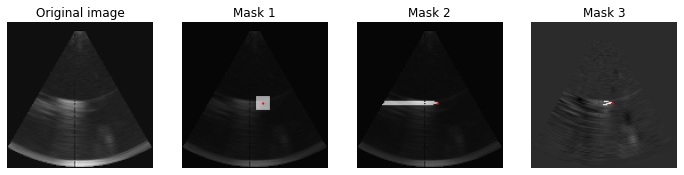

In [11]:
from matplotlib import pyplot as plt, patches

fig = plt.figure(figsize=(12, 12))

mask_tip = np.zeros((img.shape))
maskRadius = 6
mask_tip[np.around(tip_coords[0]-maskRadius).astype(int):np.around(tip_coords[0]+maskRadius).astype(int), 
                 np.around(tip_coords[1]-maskRadius).astype(int):np.around(tip_coords[1]+maskRadius).astype(int), 
                 np.around(tip_coords[2]-maskRadius).astype(int):np.around(tip_coords[2]+maskRadius).astype(int)
                ] = 1

ax = fig.add_subplot(1, 4, 1)
plt.imshow(img[:, :, int(tip_coords[2])].T, cmap="gray")
ax.set_title("Original image")
plt.axis('off')


ax = fig.add_subplot(1, 4, 2)
plt.imshow(img[:, :, int(tip_coords[2])].T, cmap="gray")
plt.imshow(mask_tip[:, :, int(tip_coords[2])].T, alpha=0.6, cmap="gray")
ax.add_patch(patches.Circle((int(tip_coords[0]), int(tip_coords[1])), radius=0.5, color='red'))
ax.set_title("Mask 1")
plt.axis('off')


ax = fig.add_subplot(1, 4, 3)
plt.imshow(img[:, :, int(tip_coords[2])].T, cmap="gray")
plt.imshow(mask_full[:, :, int(tip_coords[2])].T, alpha=0.6, cmap="gray")
ax.add_patch(patches.Circle((int(tip_coords[0]), int(tip_coords[1])), radius=0.5, color='red'))
ax.set_title("Mask 2")
plt.axis('off')


ax = fig.add_subplot(1, 4, 4)
plt.imshow(img[:, :, int(tip_coords[2])].T - img2[:, :, int(tip_coords[2])].T, cmap="gray")
plt.imshow(mask_full[:, :, int(tip_coords[2])].T-mask_full_2[:, :, int(tip_coords[2])].T, alpha=0.6, cmap="gray")
ax.add_patch(patches.Circle((int(tip_coords[0]), int(tip_coords[1])), radius=0.5, color='red'))
ax.set_title("Mask 3")
plt.axis('off')
image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'three_masks.svg'

fig.savefig(image_name, format=image_format, dpi=1200)

plt.show()

### plot process of creating Mask 3 and input image for Mask 3:

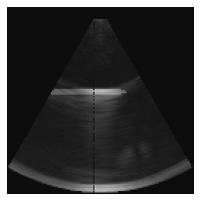

In [32]:
import h5py
import matplotlib.pyplot as plt
from utils.type_reader import get_image_array
from matplotlib import patches


n = 370

h5_file = h5py.File(X[n][0], 'r')
input_image = h5_file["img"+"_"+X[n][1][:-2]+"_"+str(10)][()]
needle_mask = h5_file["mask"+"_"+X[n][1][:-2]+"_"+str(10)][()]
label_second = h5_file["labels"+"_"+X[n][1][:-2]+"_"+str(10)][()]
h5_file.close()

fig = plt.figure()

#ax = fig.add_subplot(1, 2, 1)
#plt.imshow(input_image[:, :, int(label_first[2]), frame_first].T)
#plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T, alpha=0.2)
#ax.add_patch(patches.Circle((int(label_first[0]), int(label_first[1])), radius=1, color='red'))

ax = fig.add_subplot(1, 2, 2)
plt.imshow(input_image[:, :, int(label_second[2])].T, cmap="gray")
plt.imshow(needle_mask[:, :, int(label_second[2])].T, alpha=0.2, cmap="gray")
#ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))
fig.tight_layout()
ax.axis('off')

plt.show()

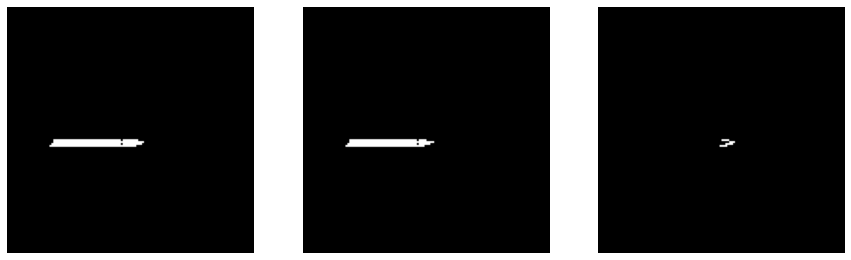

In [20]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(mask_full[:, :, int(tip_coords[2])].T, cmap='gray')
#plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T, alpha=0.2)
#ax.add_patch(patches.Circle((int(label_first[0]), int(label_first[1])), radius=1, color='red'))
ax.axis('off')

ax = fig.add_subplot(1, 3, 2)
plt.imshow(mask_full_2[:, :, int(tip_coords[2])].T, cmap='gray')
#plt.imshow(needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.2)
#ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))
ax.axis('off')

ax = fig.add_subplot(1, 3, 3)
plt.imshow(mask_full[:, :, int(tip_coords[2])].T - mask_full_2[:, :, int(tip_coords[2])].T, cmap='gray')
#plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T-needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.3)
#ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))
ax.axis('off')

plt.show()

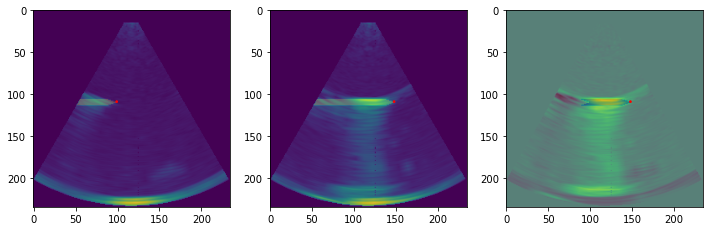

In [ ]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(input_image[:, :, int(label_first[2]), frame_first].T)
plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_first[0]), int(label_first[1])), radius=1, color='red'))


ax = fig.add_subplot(1, 3, 2)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T)
plt.imshow(needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))


ax = fig.add_subplot(1, 3, 3)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T - input_image[:, :, int(label_first[2]), frame_first].T)
plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T-needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))

plt.show()

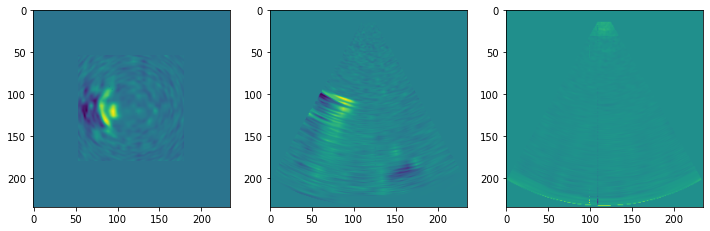

In [ ]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(input_image[:, int(label_second[1]), :, frame_second].T - input_image[:, int(label_first[1]), :, frame_first].T)


ax = fig.add_subplot(1, 3, 2)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T - input_image[:, :, int(label_first[2]), frame_first].T)



ax = fig.add_subplot(1, 3, 3)
plt.imshow(input_image[int(label_second[0]), :, :, frame_second] - input_image[int(label_first[0]), :, :, frame_first])
plt.show()

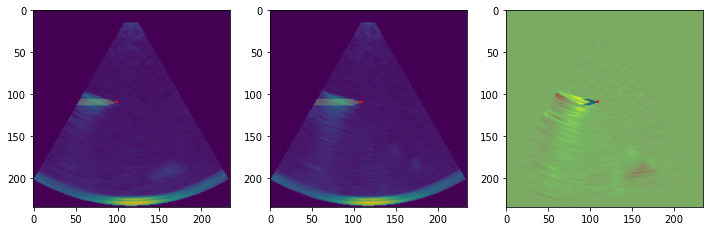

In [ ]:
frame_first = 0
frame_second = 3
label_first = labels[frame_first]
label_second = labels[frame_second]

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(input_image[:, :, int(label_first[2]), frame_first].T)
plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_first[0]), int(label_first[1])), radius=1, color='red'))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T)
plt.imshow(needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))


ax = fig.add_subplot(1, 3, 3)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T - input_image[:, :, int(label_first[2]), frame_first].T)
plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T-needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.4)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))
plt.show()

### Create an animation from one sequence of images with needle pixels and tip ground truth and save it:

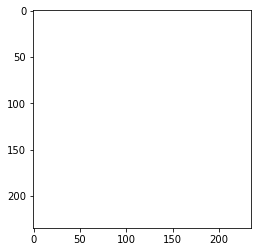

In [ ]:

import matplotlib.animation as anm

img = [] # some array of images
frames_seq = [] # for storing the generated images

fig = plt.figure()
ax = fig.add_subplot()

for i in range(needle_mask.shape[0]):
    frames_seq.append([
        plt.imshow(input_image[:, :, int(labels[i][2]), i].T), 
        plt.imshow(needle_mask[i, :, :, int(labels[i][2])].T, alpha=0.2),
        ax.add_patch(patches.Circle((int(labels[i][0]), int(labels[i][1])), radius=1, color='red'))
])

ani = anm.ArtistAnimation(fig, frames_seq)
ani.save('needle_movement.mp4')

### Check the frame diff dataset - whether everything loads correctly + whether labels are correct

In [1]:
# import all files from necessary directory
from os import listdir, path
dir = "/data/Riabova/train/resized_train/"
all_files = [path.join(dir, f) for f in listdir(dir)]
len(all_files)

98

In [138]:
FRAME_DIFF = 2

In [139]:
import numpy as np
import h5py
# merge all images in one huge array

all_frames_filenames_array = np.empty((1))
frame_nums = np.empty((1))
frame_nums_next = np.empty((1))
i = 0
for f in all_files:
    if (i%20 == 0):
        print("File "+str(i)+"...")
    h5_file = h5py.File(f, 'r')
    framesTotal = sum(item.startswith('img_') for item in list(h5_file.keys()))//11
    h5_file.close()
    all_frames_filenames_array = np.concatenate((all_frames_filenames_array, [f]*(framesTotal-FRAME_DIFF)), axis=0)
    frame_nums = np.concatenate((frame_nums, np.arange(0, framesTotal-FRAME_DIFF)), axis=0)
    frame_nums_next = np.concatenate((frame_nums_next, np.arange(FRAME_DIFF, framesTotal)), axis=0)
    i+=1

File 0...
File 20...
File 40...
File 60...
File 80...
File 100...


In [140]:
all_frames_filenames_array = all_frames_filenames_array[1:]
frame_nums = frame_nums[1:]
frame_nums_next = frame_nums_next[1:]

X = np.vstack((all_frames_filenames_array, frame_nums, frame_nums_next)).transpose()
print(X.shape)
print(X[10, :])

(2060, 3)
['/data/Riabova/train/resized_train/15_0_-9_0_0_0_4_2_1689849046042619.hdf5'
 '10.0' '12.0']


In [141]:
VALID_PERCENT = 0.2
TEST_PERCENT = 0.2
BATCH_TRAIN = 24
BATCH_VALID = 24
BATCH_TEST = 24
# note: original size - 235; resizing to 200 + batch size 5 caused cuda out of memory

In [142]:
from sklearn.model_selection import train_test_split

X_train, X_valid = train_test_split(X[:1000, :], test_size=VALID_PERCENT, random_state=42, shuffle = False)
X_test = X[1000:, :]

print(f"Total training images: {X_train.shape[0]}")
print(f"Total validation images: {X_valid.shape[0]}")
print(f"Total test images: {X_test.shape[0]}")

Total training images: 800
Total validation images: 200
Total test images: 1060


In [143]:
from utils.datasets import FrameDiffDataset, my_collate
import torch

train_dataset = FrameDiffDataset(X_train)
valid_dataset = FrameDiffDataset(X_valid)
test_dataset = FrameDiffDataset(X_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_TRAIN,shuffle=False, collate_fn=my_collate)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_VALID,shuffle=False, collate_fn=my_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_TEST,shuffle=False, collate_fn=my_collate)

In [81]:
# To check the labels
# To check the speed of accessing data. Result for batch size=24: 8s/batch
from tqdm import tqdm
for sample in tqdm(iter(train_dataloader)):
    print(sample['image'].shape)
    break

  0%|          | 0/35 [00:07<?, ?it/s]

torch.Size([24, 1, 128, 128, 128])


In [82]:
sample_first = {'image':sample['image'][0],'mask':sample['mask'][0],'label':sample['label'][0].int() }

In [84]:
np.count_nonzero(sample['mask'][0].detach().numpy())

59

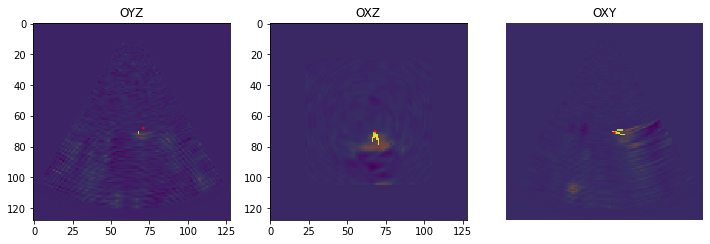

In [85]:
from utils.display_utils import show_sample
from matplotlib import pyplot as plt, patches

fig = plt.figure(figsize=(12, 12))
sample = sample_first
    
x = sample['label'][0].int()
y = sample['label'][1].int()
z = sample['label'][2].int()

ax1 = fig.add_subplot(1, 3, 1)
plt.title("OYZ")
plt.imshow(sample['image'][0, x, :, :], interpolation='none')
plt.imshow(sample['mask'][0, x, :, :], interpolation='none', alpha = 0.7)
ax1.add_patch(patches.Circle((y, z), radius=0.5, color='red'))


ax2 = fig.add_subplot(1, 3, 2)
plt.title("OXZ")
plt.imshow(sample['image'][0, :, y, :], interpolation='none')
plt.imshow(sample['mask'][0, :, y, :], interpolation='none', alpha = 0.7)
ax2.add_patch(patches.Circle((z, x), radius=0.5, color='red'))


ax3 = fig.add_subplot(1, 3, 3)
plt.title("OXY")
plt.imshow(sample['image'][0, :, :, z].T, interpolation='none')
plt.imshow(sample['mask'][0, :, :, z].T, interpolation='none', alpha = 0.7)
ax3.add_patch(patches.Circle((x, y), radius=0.5, color='red'))

plt.axis('off')
plt.show()

### Binarize all resized masks, because during resizing used wrond interpolation and now they are non-binary (<font color='red'>L</font><font color='orange'>G</font><font color='yellow'>B</font><font color='green'>T</font><font color='blue'>Q</font><font color='purple'>+</font>)

In [2]:
import numpy as np
import h5py
from utils.type_reader import mha_read_header
from utils.labels_utils import get_labels
from os import listdir, path

dir = "/data/Riabova/train/resized_train/"
all_files = [path.join(dir, f) for f in listdir(dir)]
len(all_files)

i=0
for f in all_files:
    if (i%20 == 0):
        print("File "+str(i)+"...")
    h5_file = h5py.File(f, 'r+')
    resizedMaskKeys = [key for key in list(h5_file.keys()) if key.startswith("mask") & key.endswith("10")]
    for key in resizedMaskKeys:
        previous_mask = h5_file[key][()]
        h5_file[key][...] =(previous_mask>0.5).astype(int)
    h5_file.close()
    i+=1

File 0...
File 20...
File 40...
File 60...
File 80...
File 100...


In [4]:
import h5py
import os

directory = '/data/Riabova/train/resized_train'

for filename in os.listdir(directory):
    if filename.endswith('.hdf5') or filename.endswith('.h5'):
        fullpath = os.path.join(directory, filename)
        f = h5py.File(fullpath, 'a')
        if ("labels_original_new" not in f.keys()):
            print(f)
        f.close()

### Display intermediate layer outputs of the tip mask model

In [110]:
sample_batched_full = next(iter(train_dataloader))
image_full = sample_batched_full['image'][10]
target_full = sample_batched_full['mask'][10]
labels_full = sample_batched_full['label'][10]

In [125]:
sample_batched_tip = next(iter(train_dataloader))
image_tip = sample_batched_tip['image'][10]
target_tip = sample_batched_tip['mask'][10]
labels_tip = sample_batched_tip['label'][10]

In [144]:
sample_batched_diff = next(iter(train_dataloader))
image_diff = sample_batched_diff['image'][10]
target_diff = sample_batched_diff['mask'][10]
labels_diff = sample_batched_diff['label'][10]

In [145]:
image = torch.unsqueeze(image_diff, dim=0)
image.shape

torch.Size([1, 1, 128, 128, 128])

In [146]:
# %%
import torch.nn as nn
import torch
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from models.unet import UNet
from utils.losses import IoULoss
from utils.save_model_utils import SaveBestModel

UNET_DEPTH = 4 # size of the image should divide by this number
UNET_START_FILTERS = 3
INIT_LR = 0.01

# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = UNet(out_channels = 1, n_blocks=UNET_DEPTH, start_filts = UNET_START_FILTERS).to(device)
optimizer = optim.Adam(model.parameters(), lr = INIT_LR)# optim.RMSprop(model.parameters(),lr=INIT_LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM, foreach=True)
criterion = IoULoss()

In [147]:
state = torch.load('outputs/outputs_new_diff_mask_2/epoch_200_model.pth')
    
model.load_state_dict(state['model_state_dict'])
optimizer.load_state_dict(state['optimizer_state_dict'])
model.eval()  # evaluation mode
model.to('cuda')

UNet(
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv3d(1, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv2): Conv3d(3, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (act1): ReLU()
      (act2): ReLU()
      (norm0): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm1): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DownConv(
      (conv1): Conv3d(3, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv2): Conv3d(6, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (act1): ReLU()
      (act2): ReLU()
      (norm0): BatchNorm3d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm1): BatchNorm3d(6

In [148]:
# placeholder for batch features
features = {}

def getIntermediateOutput(name):
    def hook(model, input, output):
        features[name] = output[0].detach()
    return hook

In [149]:
model.down_convs[0].register_forward_hook(getIntermediateOutput('downconv_1'))
model.down_convs[1].register_forward_hook(getIntermediateOutput('downconv_2'))
model.down_convs[2].register_forward_hook(getIntermediateOutput('downconv_3'))
model.down_convs[3].register_forward_hook(getIntermediateOutput('downconv_4'))
model.up_convs[0].register_forward_hook(getIntermediateOutput('upconv_1'))
model.up_convs[1].register_forward_hook(getIntermediateOutput('upconv_2'))
model.up_convs[2].register_forward_hook(getIntermediateOutput('upconv_3'))


In [131]:
out_tip = model(image.to('cuda'))

In [132]:
downconv_1_tip = features['downconv_1'].cpu().numpy()
downconv_2_tip = features['downconv_2'].cpu().numpy()
downconv_3_tip = features['downconv_3'].cpu().numpy()
downconv_4_tip = features['downconv_4'].cpu().numpy()
upconv_1_tip = features['upconv_1'].cpu().numpy()
upconv_2_tip = features['upconv_2'].cpu().numpy()
upconv_3_tip = features['upconv_3'].cpu().numpy()

In [133]:
labels_tip

tensor([71., 71., 59.])

In [116]:
out_full = model(image.to('cuda'))

In [117]:
downconv_1_full = features['downconv_1'].cpu().numpy()
downconv_2_full = features['downconv_2'].cpu().numpy()
downconv_3_full = features['downconv_3'].cpu().numpy()
downconv_4_full = features['downconv_4'].cpu().numpy()
upconv_1_full = features['upconv_1'].cpu().numpy()
upconv_2_full = features['upconv_2'].cpu().numpy()
upconv_3_full = features['upconv_3'].cpu().numpy()

In [118]:
labels_full

tensor([71., 71., 59.])

In [150]:
out_diff = model(image.to('cuda'))

In [151]:
downconv_1_diff = features['downconv_1'].cpu().numpy()
downconv_2_diff = features['downconv_2'].cpu().numpy()
downconv_3_diff = features['downconv_3'].cpu().numpy()
downconv_4_diff = features['downconv_4'].cpu().numpy()
upconv_1_diff = features['upconv_1'].cpu().numpy()
upconv_2_diff = features['upconv_2'].cpu().numpy()
upconv_3_diff = features['upconv_3'].cpu().numpy()

In [152]:
labels_diff

tensor([73., 71., 59.])

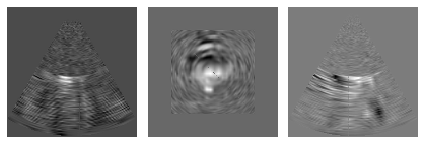

In [154]:
# Create figure and axes 
import matplotlib.pyplot as plt
import torch 

fig, axs = plt.subplots(1,3, figsize=(6,18))
axs = axs.flatten() 

pred_diff = torch.sigmoid(out_diff).cpu().detach().numpy()[0][0]
mask_diff = target_diff[0].cpu().detach().numpy()
img = image[0][0].cpu().detach().numpy()

axs[0].imshow(img[71, :, :],cmap='gray', interpolation='none')
axs[0].axis('off')
axs[1].imshow(img[:, 71, :],cmap='gray',interpolation='none')
axs[1].axis('off')
axs[2].imshow(img[:, :, 59].T,cmap='gray',interpolation='none')
axs[2].axis('off')

fig.tight_layout()
plt.show()

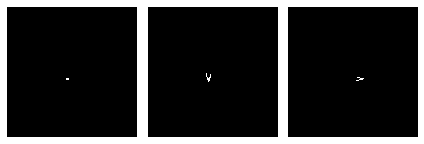

In [155]:
# Create figure and axes 
import torch 

fig, axs = plt.subplots(1,3, figsize=(6,18))
axs = axs.flatten() 

axs[0].imshow(mask_diff[71, :, :],cmap='gray', interpolation='none')
axs[0].axis('off')
axs[1].imshow(mask_diff[:, 71, :],cmap='gray',interpolation='none')
axs[1].axis('off')
axs[2].imshow(mask_diff[:, :, 59].T,cmap='gray',interpolation='none')
axs[2].axis('off')

fig.tight_layout()
plt.show()

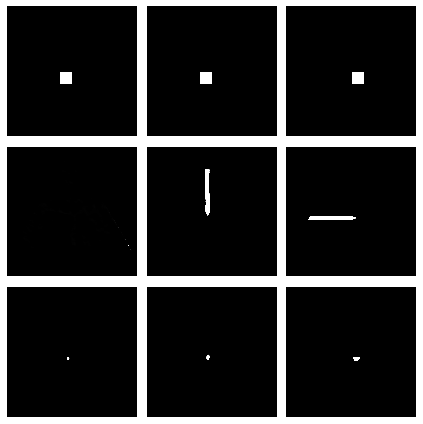

In [159]:
# Create figure and axes 
import torch 

fig, axs = plt.subplots(3,3, figsize=(6,6))
axs = axs.flatten() 

pred_diff = torch.sigmoid(out_diff).cpu().detach().numpy()[0][0]
pred_tip = torch.sigmoid(out_tip).cpu().detach().numpy()[0][0]
pred_full = torch.sigmoid(out_full).cpu().detach().numpy()[0][0]


axs[0].imshow(pred_tip[71, :, :],cmap='gray', interpolation='none')
axs[0].axis('off')
axs[1].imshow(pred_tip[:, 71, :],cmap='gray',interpolation='none')
axs[1].axis('off')
axs[2].imshow(pred_tip[:, :, 59].T,cmap='gray',interpolation='none')
axs[2].axis('off')

axs[3].imshow(pred_full[71, :, :],cmap='gray', interpolation='none')
axs[3].axis('off')
axs[4].imshow(pred_full[:, 71, :],cmap='gray',interpolation='none')
axs[4].axis('off')
axs[5].imshow(pred_full[:, :, 59].T,cmap='gray',interpolation='none')
axs[5].axis('off')

axs[6].imshow(pred_diff[71, :, :],cmap='gray', interpolation='none')
axs[6].axis('off')
axs[7].imshow(pred_diff[:, 71, :],cmap='gray',interpolation='none')
axs[7].axis('off')
axs[8].imshow(pred_diff[:, :, 59].T,cmap='gray',interpolation='none')
axs[8].axis('off')

fig.tight_layout()
plt.show()

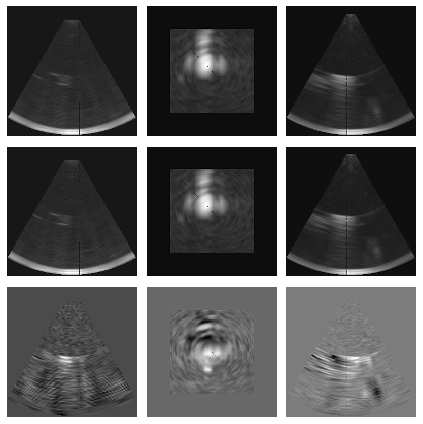

In [160]:
# Create figure and axes 
import torch 

fig, axs = plt.subplots(3,3, figsize=(6,6))
axs = axs.flatten() 

img_tip = image_tip[0].cpu().detach().numpy()
img_diff = image_diff[0].cpu().detach().numpy()
img_full = image_full[0].cpu().detach().numpy()


axs[0].imshow(img_tip[71, :, :],cmap='gray', interpolation='none')
axs[0].axis('off')
axs[1].imshow(img_tip[:, 71, :],cmap='gray',interpolation='none')
axs[1].axis('off')
axs[2].imshow(img_tip[:, :, 59].T,cmap='gray',interpolation='none')
axs[2].axis('off')

axs[3].imshow(img_full[71, :, :],cmap='gray', interpolation='none')
axs[3].axis('off')
axs[4].imshow(img_full[:, 71, :],cmap='gray',interpolation='none')
axs[4].axis('off')
axs[5].imshow(img_full[:, :, 59].T,cmap='gray',interpolation='none')
axs[5].axis('off')

axs[6].imshow(img_diff[71, :, :],cmap='gray', interpolation='none')
axs[6].axis('off')
axs[7].imshow(img_diff[:, 71, :],cmap='gray',interpolation='none')
axs[7].axis('off')
axs[8].imshow(img_diff[:, :, 59].T,cmap='gray',interpolation='none')
axs[8].axis('off')

fig.tight_layout()
plt.show()

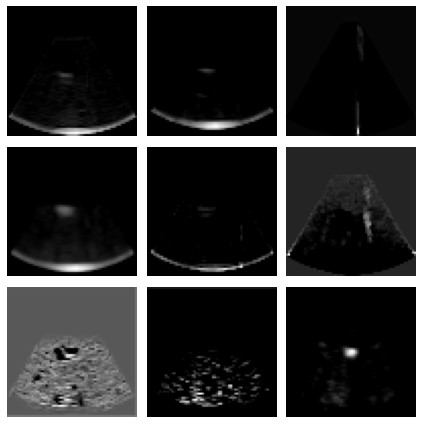

In [168]:
import random
# size of first layer ouput: 1*3*64*64*64

# Create figure and axes 
fig, axs = plt.subplots(3, 3, figsize=(6,6))

# Plot each data element on subplot
for j in range(3):
        axs[0,j].imshow(downconv_1_tip[0, j, :, :, random.randint(30, 50)].T,cmap='gray')
        axs[0,j].axis('off')
        axs[1,j].imshow(downconv_1_full[0, j, :, :, random.randint(30, 50)].T,cmap='gray')
        axs[1,j].axis('off')
        axs[2,j].imshow(downconv_1_diff[0, j, :, :, random.randint(30, 50)].T,cmap='gray')
        axs[2,j].axis('off')
fig.tight_layout()
plt.show()

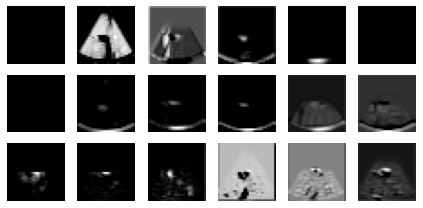

In [170]:
from matplotlib import pyplot as plt

# size of second layer ouput: (1, 6, 32, 32, 32)

# Create figure and axes 
fig, axs = plt.subplots(3,6, figsize=(6,3))

# Plot each data element on subplot
for j in range(6):
    sliceNum = random.randint(5, 20)
    axs[0,j].imshow(downconv_2_tip[0, j, :, :, sliceNum].T,cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(downconv_2_full[0, j, :, :, sliceNum].T,cmap='gray')
    axs[1,j].axis('off')
    axs[2,j].imshow(downconv_2_diff[0, j, :, :, sliceNum].T,cmap='gray')
    axs[2,j].axis('off')

fig.tight_layout()
plt.show()

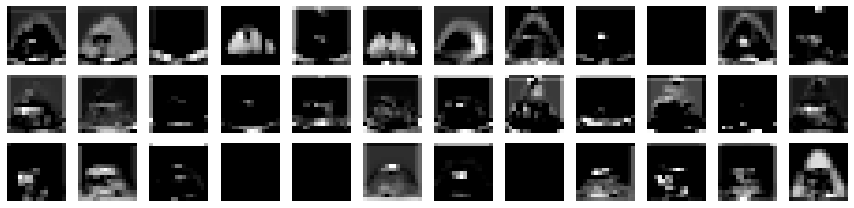

In [171]:
from matplotlib import pyplot as plt

# size of third layer ouput: (1, 12, 16, 16, 16)

# Create figure and axes 
fig, axs = plt.subplots(3,12, figsize=(12,3))

# Plot each data element on subplot
for j in range(12):
    sliceNum = random.randint(3,12)
    axs[0,j].imshow(downconv_3_tip[0, j, :, :, sliceNum].T,cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(downconv_3_full[0, j, :, :, sliceNum].T,cmap='gray')
    axs[1,j].axis('off')
    axs[2,j].imshow(downconv_3_diff[0, j, :, :, sliceNum].T,cmap='gray')
    axs[2,j].axis('off')

fig.tight_layout()
plt.show()

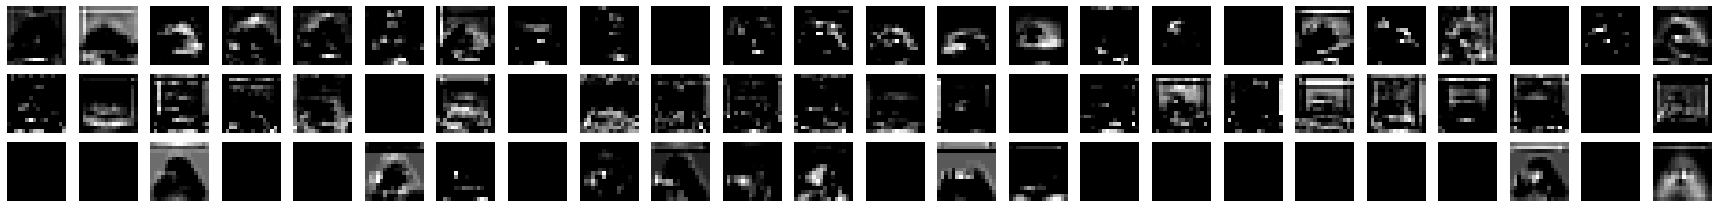

In [172]:
from matplotlib import pyplot as plt

# size of fourth layer ouput: (1, 24, 16, 16, 16)

# Create figure and axes 
fig, axs = plt.subplots(3,24, figsize=(24,3))

# Plot each data element on subplot
for j in range(24):
    sliceNum = random.randint(3,12)
    for i in range(3):
        axs[0,j].imshow(downconv_4_tip[0, j, :, :, sliceNum].T,cmap='gray')
        axs[0,j].axis('off')
        axs[1,j].imshow(downconv_4_full[0, j, :, :, sliceNum].T,cmap='gray')
        axs[1,j].axis('off')
        axs[2,j].imshow(downconv_4_diff[0, j, :, :, sliceNum].T,cmap='gray')
        axs[2,j].axis('off')


fig.tight_layout()
plt.show()

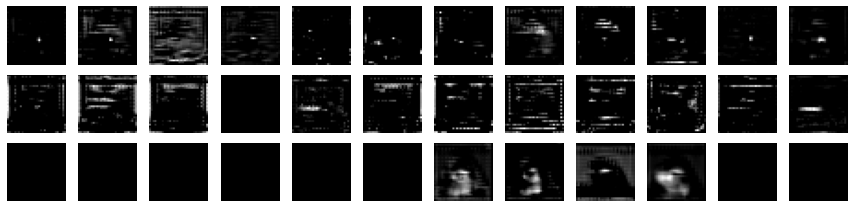

In [176]:
from matplotlib import pyplot as plt

# size of first upconv layer ouput: (12, 32, 32, 32)

# Create figure and axes 
fig, axs = plt.subplots(3,12, figsize=(12,3))

# Plot each data element on subplot
for j in range(12):
    sliceNum = random.randint(7, 20)
    axs[0,j].imshow(upconv_1_tip[j, :, :, sliceNum].T,cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(upconv_1_full[j, :, :, sliceNum].T,cmap='gray')
    axs[1,j].axis('off')
    axs[2,j].imshow(upconv_1_diff[j, :, :, sliceNum].T,cmap='gray')
    axs[2,j].axis('off')

fig.tight_layout()
plt.show()

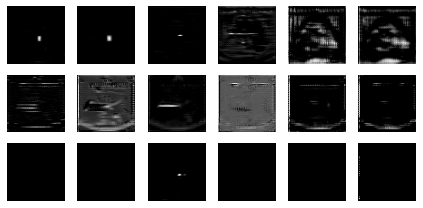

In [180]:
from matplotlib import pyplot as plt

# size of second upconv layer ouput: 6*64*64*64

# Create figure and axes 
fig, axs = plt.subplots(3,6, figsize=(6,3))

# Plot each data element on subplot
for j in range(6):
    sliceNum = random.randint(20, 45)
    axs[0,j].imshow(upconv_2_tip[j, :, :, sliceNum].T,cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(upconv_2_full[j, :, :, sliceNum].T,cmap='gray')
    axs[1,j].axis('off')
    axs[2,j].imshow(upconv_2_diff[j, :, :, sliceNum].T,cmap='gray')
    axs[2,j].axis('off')

fig.tight_layout()
plt.show()

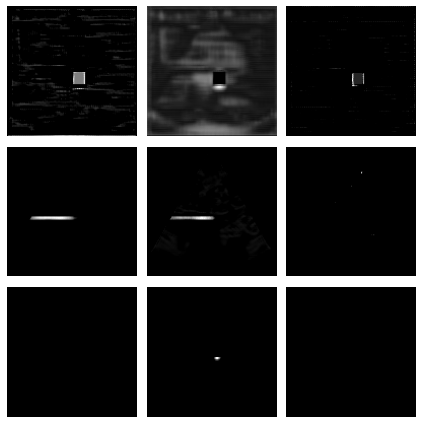

In [192]:
from matplotlib import pyplot as plt

# size of third upconv layer ouput: 3*128*128*128

# Create figure and axes 
fig, axs = plt.subplots(3, 3, figsize=(6, 6))

# Plot each data element on subplot
for j in range(3):
    sliceNum = random.randint(45, 75)
    axs[0,j].imshow(upconv_3_tip[j, :, :, sliceNum].T,cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(upconv_3_full[j, :, :, sliceNum].T,cmap='gray')
    axs[1,j].axis('off')
    axs[2,j].imshow(upconv_3_diff[j, :, :, sliceNum].T,cmap='gray')
    axs[2,j].axis('off')

fig.tight_layout()
plt.show()

In [14]:
sample_batched = next(iter(train_dataloader))
image = sample_batched['image'][0]
target = sample_batched['mask'][0]
labels = sample_batched['label'][0]
sample = {'label':labels, 'mask':target, 'image':image}

In [ ]:
image = torch.unsqueeze(image, dim=0)
image.shape

In [119]:
# %%
import torch.nn as nn
import torch
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from models.unet import UNet
from utils.losses import IoULoss
from utils.save_model_utils import SaveBestModel

UNET_DEPTH = 4 # size of the image should divide by this number
UNET_START_FILTERS = 3
INIT_LR = 0.01
PATH_DIR = 'outputs/outputs_new'

# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = UNet(out_channels = 1, n_blocks=UNET_DEPTH, start_filts = UNET_START_FILTERS).to(device)
optimizer = optim.Adam(model.parameters(), lr = INIT_LR)# optim.RMSprop(model.parameters(),lr=INIT_LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM, foreach=True)
criterion = IoULoss()

In [120]:
state = torch.load('outputs/outputs_new_full_mask/epoch_200_model.pth')
    
model.load_state_dict(state['model_state_dict'])
optimizer.load_state_dict(state['optimizer_state_dict'])
model.eval()  # evaluation mode
model.to('cuda')

UNet(
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv3d(1, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv2): Conv3d(3, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (act1): ReLU()
      (act2): ReLU()
      (norm0): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm1): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DownConv(
      (conv1): Conv3d(3, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv2): Conv3d(6, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (act1): ReLU()
      (act2): ReLU()
      (norm0): BatchNorm3d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm1): BatchNorm3d(6

In [121]:
# placeholder for batch features
features = {}

def getIntermediateOutput(name):
    def hook(model, input, output):
        features[name] = output[0].detach()
    return hook

In [122]:
model.down_convs[0].register_forward_hook(getIntermediateOutput('first_downconv'))
model.down_convs[1].register_forward_hook(getIntermediateOutput('second_downconv'))
model.down_convs[2].register_forward_hook(getIntermediateOutput('third_downconv'))
model.down_convs[3].register_forward_hook(getIntermediateOutput('fourth_downconv'))

In [123]:
out = model(image.to('cuda'))

In [126]:
first_downconv_output = features['first_downconv'].cpu().numpy()
second_downconv_output = features['second_downconv'].cpu().numpy()
third_downconv_output = features['third_downconv'].cpu().numpy()
fourth_downconv_output = features['fourth_downconv'].cpu().numpy()

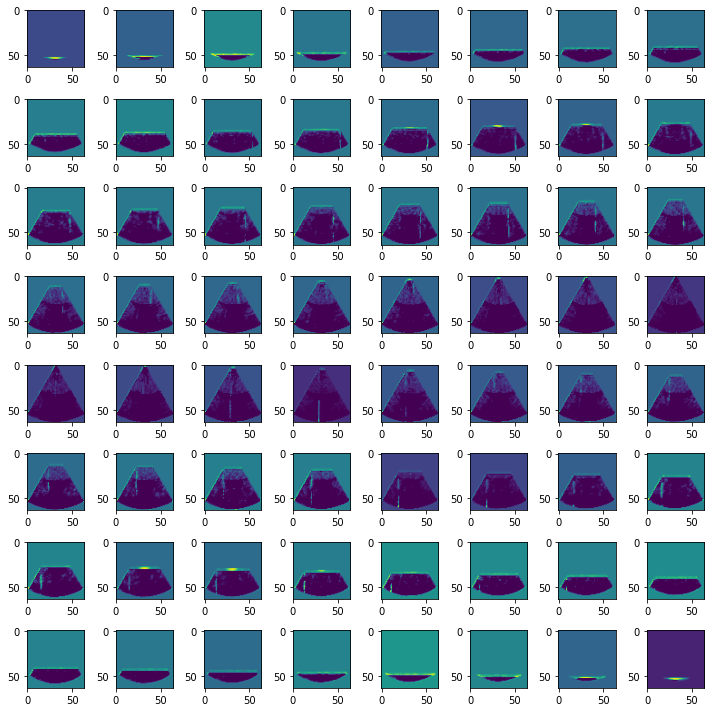

In [141]:
from matplotlib import pyplot as plt

# size of first layer ouput: 3*64*64*64

# Create figure and axes 
fig, axs = plt.subplots(8, 8, figsize=(10,10))
axs = axs.flatten() 

# Plot each data element on subplot
for i, ax in enumerate(axs):
    ax.imshow(first_downconv_output[0, 1, i])
    ax.axis('off')

fig.tight_layout()
plt.show()

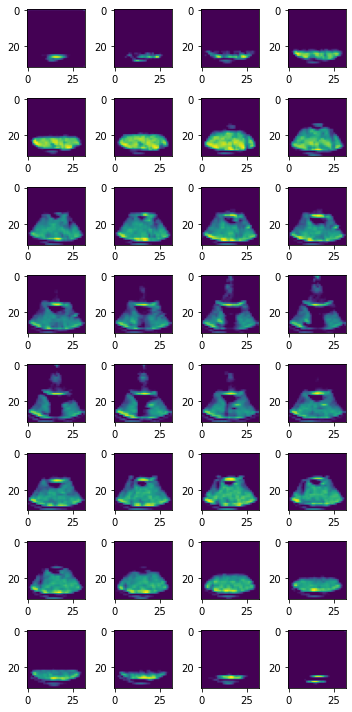

In [159]:
from matplotlib import pyplot as plt

# size of first layer ouput: 6*32*32*32

# Create figure and axes 
fig, axs = plt.subplots(8, 4, figsize=(5,10))
axs = axs.flatten() 

# Plot each data element on subplot
for i, ax in enumerate(axs):
    ax.imshow(second_downconv_output[0, 5, i])a
    x.axis('off')

fig.tight_layout()
plt.show()

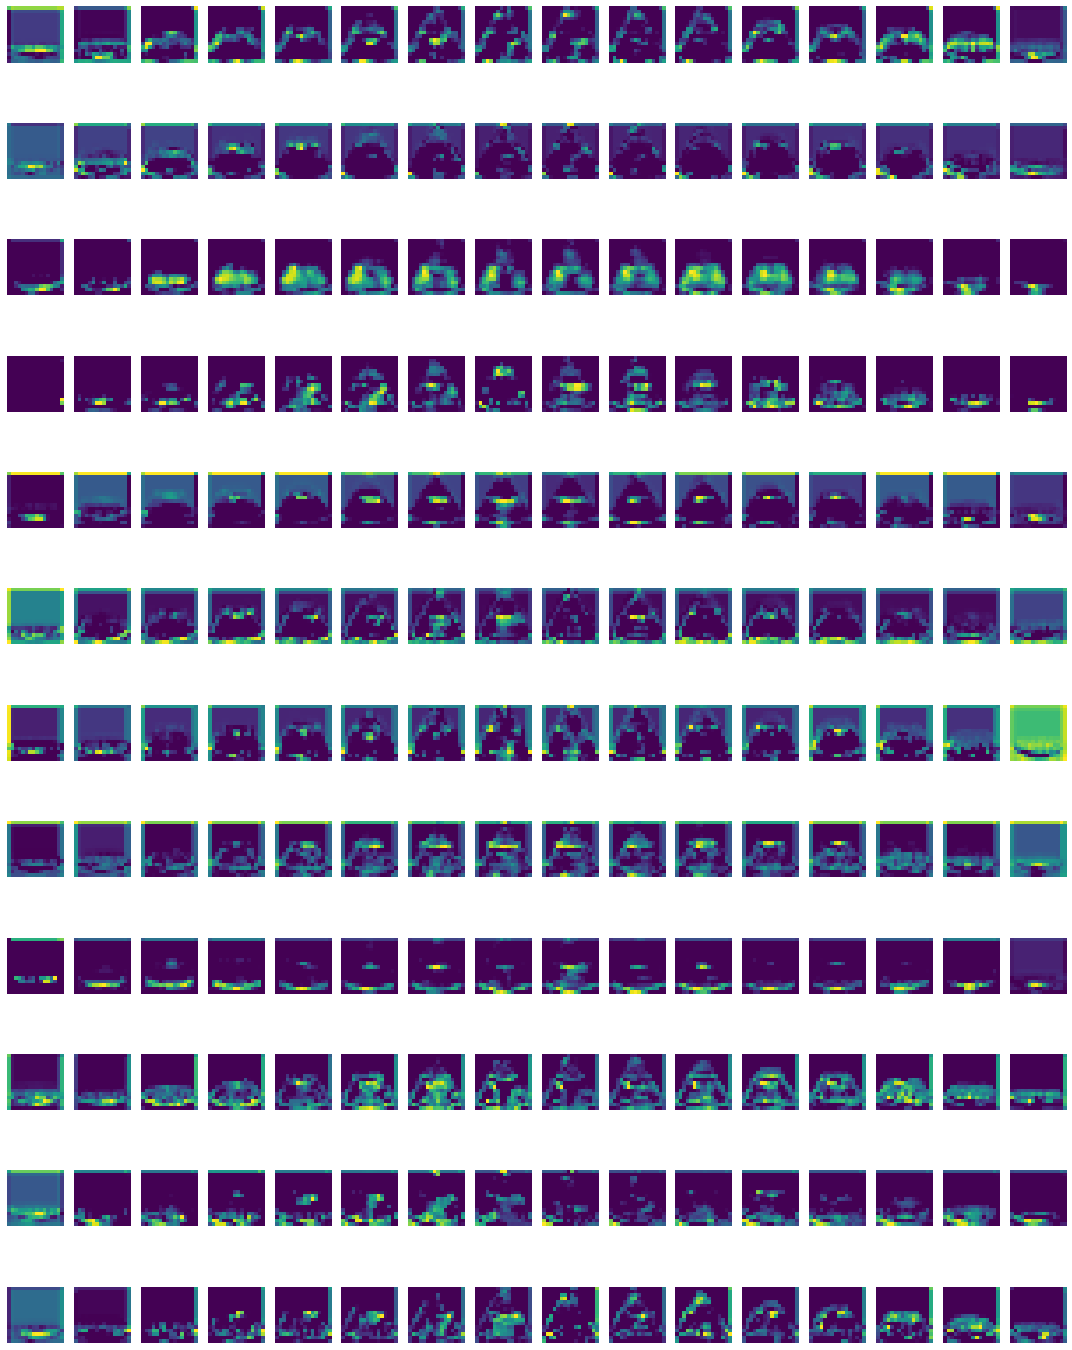

In [163]:
from matplotlib import pyplot as plt

# size of third layer ouput: (12, 16, 16, 16)

# Create figure and axes 
fig, axs = plt.subplots(12, 16, figsize=(15,20))

# Plot each data element on subplot
for i in range(12):
    for j in range(16):
        axs[i,j].imshow(third_downconv_output[0, i, j])
        axs[i,j].axis('off')

fig.tight_layout()
plt.show()

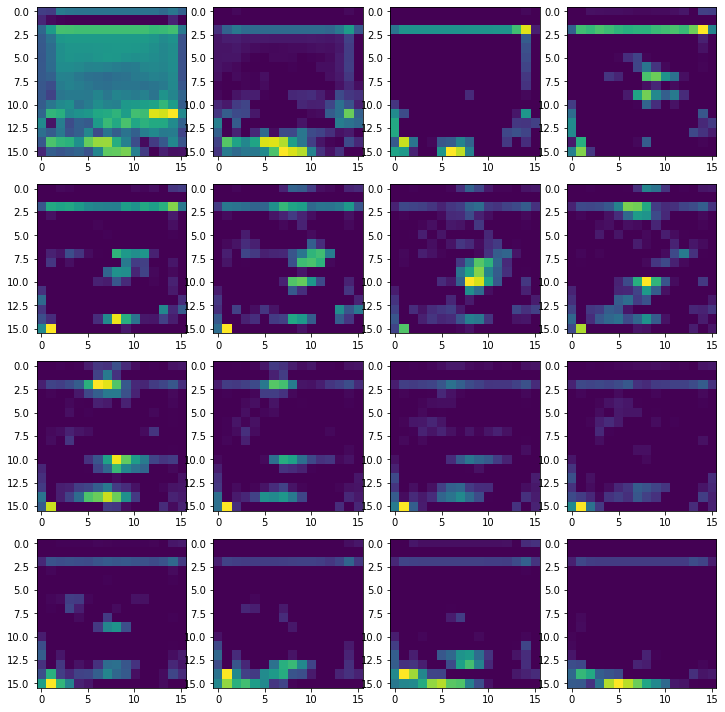

In [155]:
from matplotlib import pyplot as plt

# size of fourth layer ouput: (24, 16, 16, 16)

# Create figure and axes 
fig, axs = plt.subplots(4, 4, figsize=(10,10))
axs = axs.flatten() 

# Plot each data element on subplot
for i, ax in enumerate(axs):
    ax.imshow(fourth_downconv_output[0, 5, i])

fig.tight_layout()
plt.show()

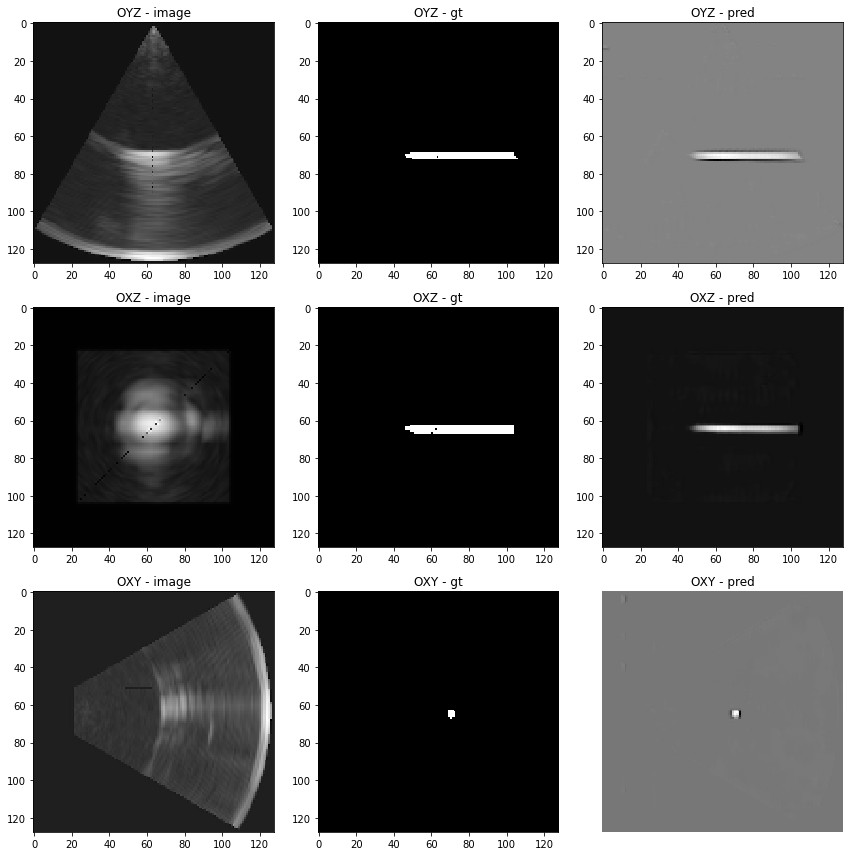

In [37]:
from utils.save_model_utils import save_sample_mask

save_sample_mask(0, 0, image[0], out[0], target, path = "", save = False)

In [1]:
import h5py
new_file = h5py.File('outputs/outputs_new_full_mask_2'+'/train_test_data.hdf5', 'r')
print(new_file.keys())

<KeysViewHDF5 ['test_loss', 'test_pixelwise_accuracy', 'test_precision', 'test_recall', 'test_tip_pixel_distance', 'tr_lr', 'tr_pixelwise_accuracy', 'tr_precisions', 'tr_recalls', 'tr_tip_pixel_distance', 'training_loss', 'valid_loss']>


In [7]:
print(new_file['test_pixelwise_accuracy'][()])

99.99658191526258


### Print test values for each mask type

In [1]:
import h5py
'''print("FULL MASK:")
new_file = h5py.File('outputs/outputs_new_full_mask_2'+'/train_test_data.hdf5', 'r')
testKeys = [key for key in list(new_file.keys()) if key[-7:] == "correct"]
for key in testKeys:
    print(key, new_file[key][()])
new_file.close()
print("TIP MASK:")
new_file = h5py.File('outputs/outputs_new_tip_mask_2'+'/train_test_data.hdf5', 'r')
testKeys = [key for key in list(new_file.keys()) if key[-7:] == "correct"]
for key in testKeys:
    print(key, new_file[key][()])
new_file.close()'''
print("FRAME_DIFF MASK:")
new_file = h5py.File('outputs/outputs_new_diff_mask_2'+'/train_test_data.hdf5', 'r')
testKeys = [key for key in list(new_file.keys())]
for key in testKeys:
    print(key)
new_file.close()

FRAME_DIFF MASK:
test_loss
test_loss_correct
test_loss_max_correct
test_loss_min_correct
test_pixelwise_accuracy
test_pixelwise_accuracy_correct
test_precision
test_precision_correct
test_recall
test_recall_correct
test_tip_pixel_distance
test_tip_pixel_distance_correct
test_tip_pixel_distance_max_correct
test_tip_pixel_distance_min_correct
tr_lr
tr_pixelwise_accuracy
tr_precisions
tr_recalls
tr_tip_pixel_distance
training_loss
valid_loss


In [2]:
new_file = h5py.File('outputs/outputs_new_diff_mask_2'+'/train_test_data.hdf5', 'r')
tr_precision = new_file['tr_precisions'][-1]
tr_recall = new_file['tr_recalls'][-1]
new_file.close()
print(tr_precision, tr_recall)

42.91353908413691 58.1983578966019


In [46]:
new_file = h5py.File('outputs/outputs_new_tip_mask_2'+'/train_test_data.hdf5', 'r')
tr_loss_1 = new_file['training_loss'][()]
valid_loss_1 = new_file['valid_loss'][()]
pr_1 = new_file['tr_precisions'][()]
rec_1 = new_file['tr_recalls'][()]

new_file.close()
new_file = h5py.File('outputs/outputs_new_full_mask_2'+'/train_test_data.hdf5', 'r')
tr_loss_2 = new_file['training_loss'][()]
valid_loss_2 = new_file['valid_loss'][()]
pr_2 = new_file['tr_precisions'][()]
rec_2 = new_file['tr_recalls'][()]

new_file.close()
new_file = h5py.File('outputs/outputs_new_diff_mask_2'+'/train_test_data.hdf5', 'r')
tr_loss_3 = new_file['training_loss'][()]
valid_loss_3 = new_file['valid_loss'][()]
pr_3 = new_file['tr_precisions'][()]
rec_3 = new_file['tr_recalls'][()]

new_file.close()

In [29]:
tr_loss_1.shape

(200,)

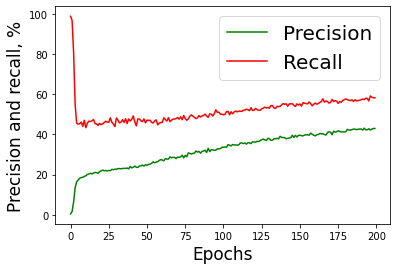

In [63]:
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.titlesize'] = 20

# loss plots
fig = plt.figure()
plt.plot(np.arange(200), pr_3, color='green', linestyle='-', label='Precision')
plt.plot(np.arange(200), rec_3, color='red', linestyle='-', label='Recall')

#plt.title("Losses over epochs")
#plt.title("Mask 1")
plt.xlabel('Epochs')
plt.ylabel('Precision and recall, %')
plt.legend(fontsize="20")
plt.show()

image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'pr_rec_3.svg'

fig.savefig(image_name, format=image_format, dpi=1500)


In [33]:
print(tr_loss_1, valid_loss_1)
print(tr_loss_2, valid_loss_2)
print(tr_loss_3, valid_loss_3)

0.07254053399806543 0.09164036273965367
0.09239654998256736 0.10272417358449988
0.6707982141920861 0.6746233999729156


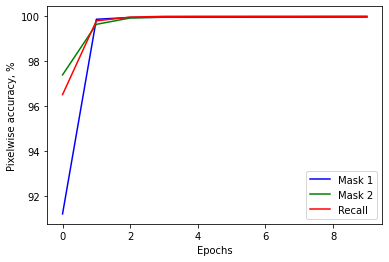

In [198]:
# loss plots
plt.figure()
plt.plot(np.arange(10), tr_acc_1[:10], color='blue', linestyle='-', label='Mask 1')
plt.plot(np.arange(10), tr_acc_2[:10], color='green', linestyle='-', label='Mask 2')
plt.plot(np.arange(10), tr_acc_3[:10], color='red', linestyle='-', label='Recall')

#plt.title("Losses over epochs")
plt.xlabel('Epochs')
plt.ylabel('Pixelwise accuracy, %')
plt.legend()
plt.show()